% packages

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns


In [ ]:
# %% data import
iris = load_iris()
X = iris.data
y = iris.target

%% train test split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

%% convert to float32

In [ ]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

%% dataset

In [53]:
class IrisData(Dataset):
    def __init__(self, X_train, y_train)->None:
        super().__init__()
        self.X = torch.from_numpy(X_train)
        self.y = torch.from_numpy(y_train)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.X.shape[0]
    def __len__(self):
        return self.len
    def __getitem__(self, index):
        return self.X[index], self.y[index]

%% dataloader

In [54]:
iris_data = IrisData(X_train, y_train)
train_loader = DataLoader(iris_data, batch_size=32)

%% check dims

In [55]:
print(f"X:number of independant vals {iris_data.X.shape}, y: number of dependant vars:{iris_data.y.shape}")

X:number of independant vals torch.Size([120, 4]), y: number of dependant vars:torch.Size([120])


%% define class

In [62]:
class MultiClassNet(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN_FEATURES):
        super().__init__()
        self.lin1 = nn.Linear(NUM_FEATURES, HIDDEN_FEATURES)
        self.lin2 = nn.Linear(HIDDEN_FEATURES, NUM_CLASSES)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # x = x.to(torch.float32)
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = self.log_softmax(x)
        return x
    

In [63]:
# %% hyper parameters
NUM_FEATURES = iris_data.X.shape[1]
HIDDEN = 6
NUM_CLASSES = len(iris_data.y.unique())


In [64]:
# %% create model instance
model = MultiClassNet(NUM_FEATURES=NUM_FEATURES, NUM_CLASSES=NUM_CLASSES, HIDDEN_FEATURES=HIDDEN)

%% loss function

In [65]:
criterion = nn.CrossEntropyLoss()

In [72]:
# %% optimizer
LR = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

%% training

In [73]:
NUM_EPOCHS = 100
losses = []
for epoch in range(NUM_EPOCHS):
    for x, y in train_loader:

        # init gradient
        optimizer.zero_grad()
        
        # forward pass
        y_pred_log = model(x)

        # calc losses
        loss = criterion(y_pred_log, y)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
    losses.append(float(loss.data.detach().numpy()))

<Axes: >

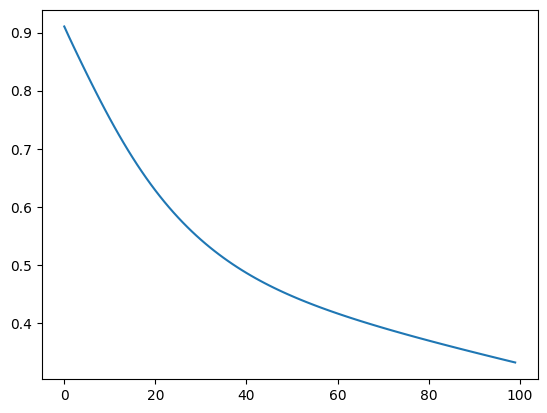

In [74]:
# %% show losses over epochs
sns.lineplot(x=range(NUM_EPOCHS), y= losses)

%% test the model

In [75]:
X_test_torch = torch.from_numpy(X_test)
with torch.no_grad():
    y_test_log = model(X_test_torch)
    y_test_pred = torch.max(y_test_log.data, 1)

%% Accuracy

In [76]:
accuracy_score(y_test, y_test_pred.indices)

0.9333333333333333

naive classifier


In [77]:
from collections import Counter
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier accuracy: {most_common_cnt/len(y_test)*100}%")

Naive Classifier accuracy: 40.0%
